### Description:

This project aims to design a biomass (corn stover) biofuel (bioethanol) supply chain network. This supply chain network and its associated activities are shown in figures below. There are three stages for this supply chain network including suppliers, bioethanol plantsrefineris, and demand zones. The biomass feedstock flows from the suppliers to the biorefineries by trucks. Then the bioethanol produced in biorefineries either goes to in-state demand zones by trucks or to out-of-state demand zones by rail.

This project is a part of my published article titled "First-generation vs. second-generation: A market incentives analysis for bioethanol supply chains with carbon policies" which can be found here: https://www.sciencedirect.com/science/article/abs/pii/S0306261920311132

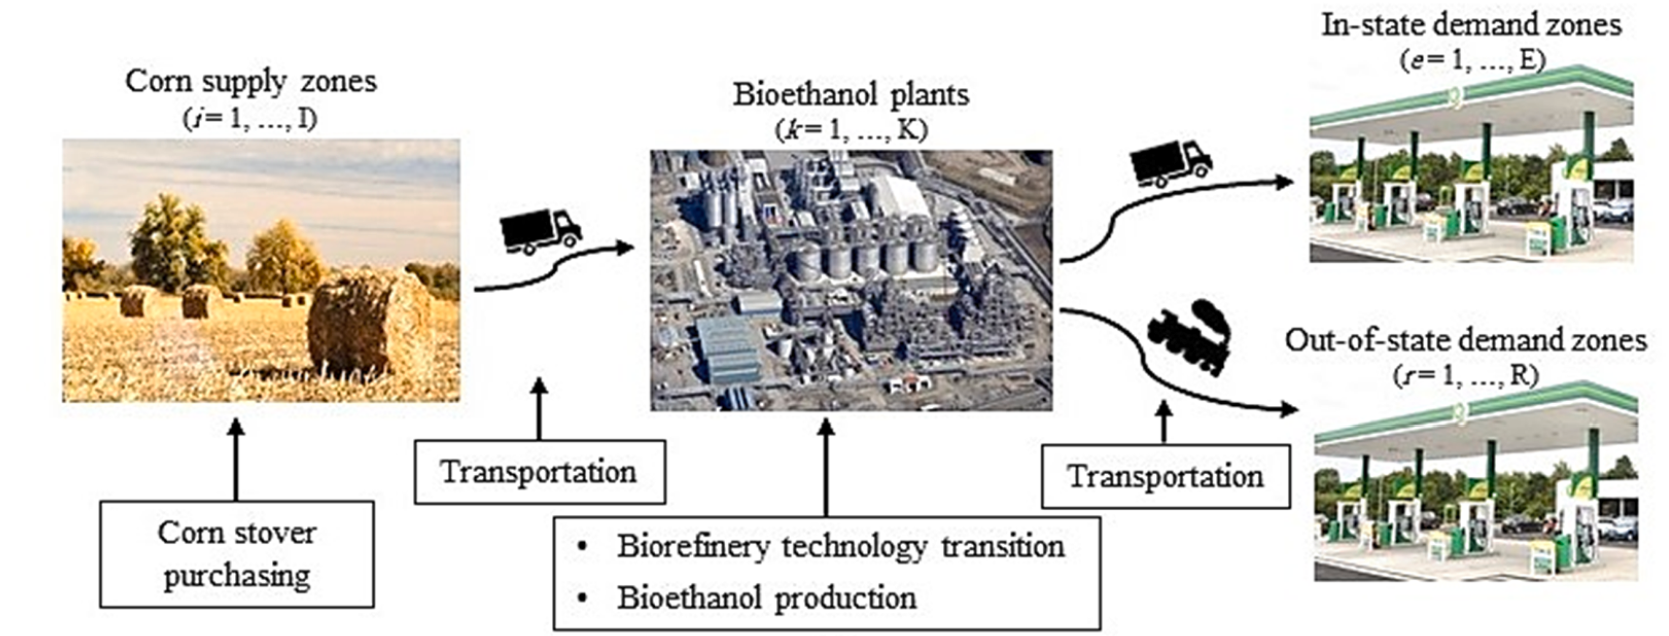

In [31]:
from IPython import display
display.Image('D:\Other\My_Optimization_projects\PhD Big biomass second incentive paper\Files from PhD\CornStover_SC.png',
             width=600, height=500)

To validate our study, we considered North Dakota (ND) as one of the leading states in corn production in the US. There are 53 counties in ND that have been divided into nine Agricultural Statistical Districts (ASDs) serving as suppliers (i.e., NE, EC, SE, NC, CENTRAL, SC, NW, WC, and SW). Also, there are already five bioethanol plants in ND (i.e., Red Train Energy, Blue Flint Ethanol, Dakota Spirit AgEnergy, Tharaldson Ethanol, and Guardian Hankinson) that are producing almost 443 million gallons of bioethanol each year from corn which have been considered as the potential  locations for biorefineries.

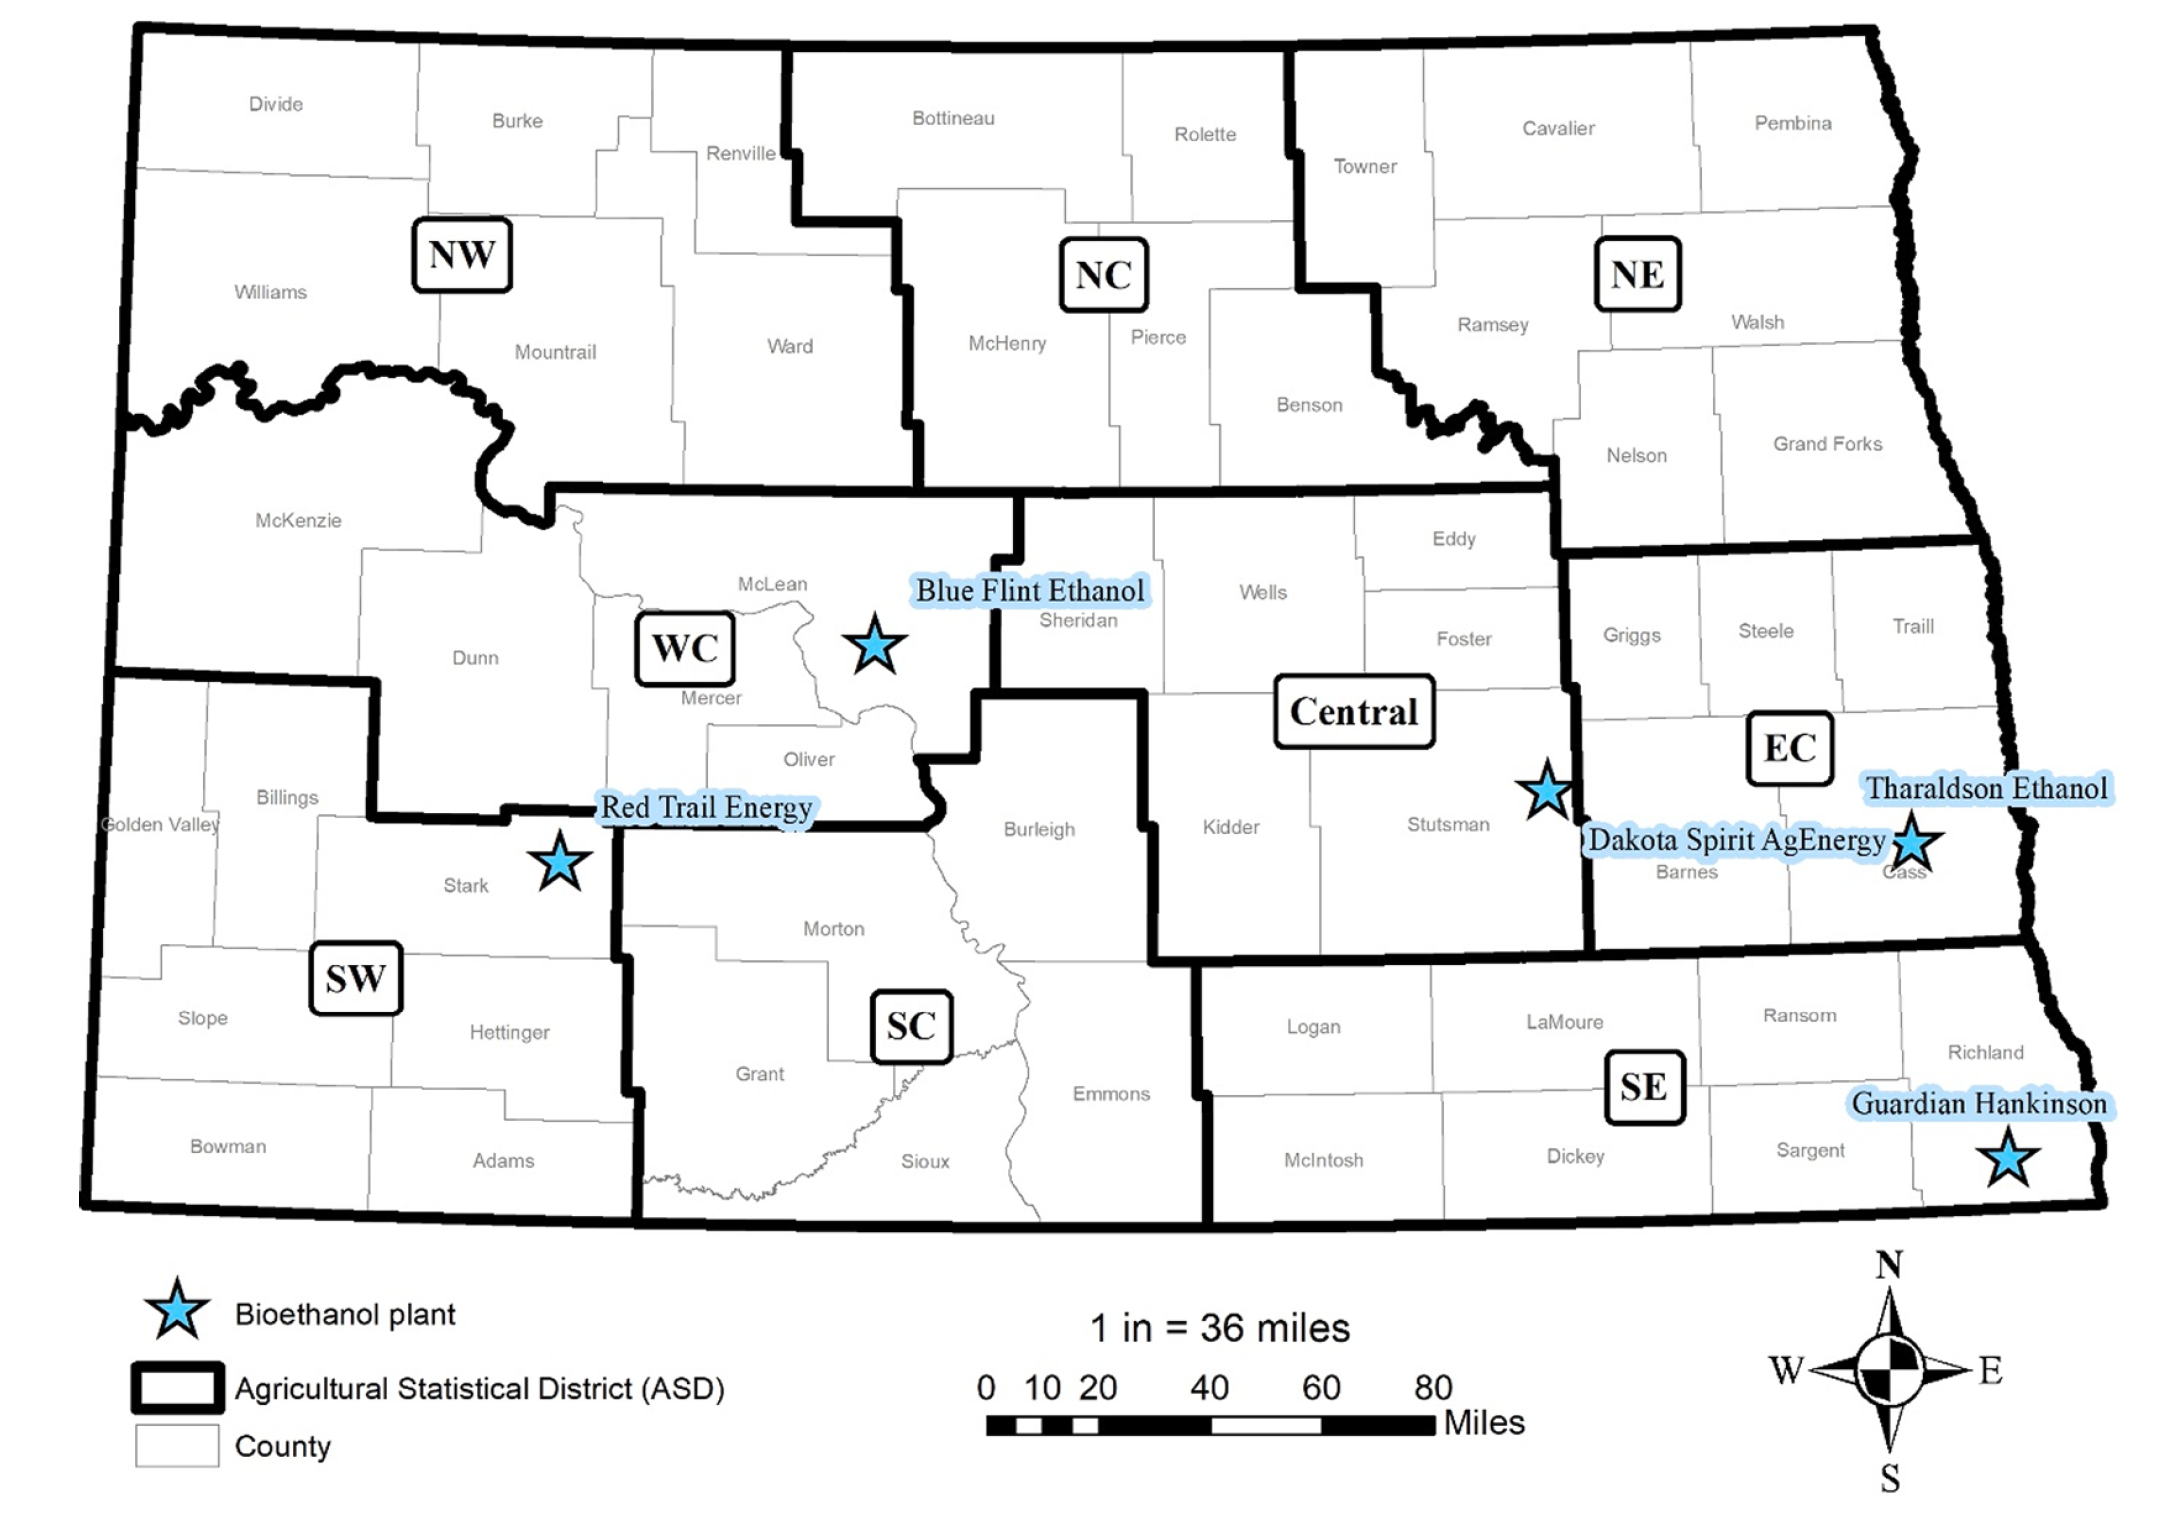

In [32]:
from IPython import display
display.Image('D:\Other\My_Optimization_projects\PhD Big biomass second incentive paper\Files from PhD\Biorefineries_locations.png',
             width=600, height=500)

The bioethanol produced in ND is sold not only within the state but also to other states in the US. Thus, we divided the bioethanol demand zones into two categories that are referred as “in-state” and “out-of-state” demand zones. Based on discussions with bioethanol experts in ND, there are six in-state demand zones including Fargo, Grand Forks, Jamestown, Bismarck, Dickinson, and Minot which have fuel racks, where bioethanol is blended with gasoline. These demand zones are all located in ND. Moreover, there are four out-of-state demand zones including Houston (TX), Los Angeles (CA), Portland (OR), and Seattle (WA). Considering the out-of-state demand zones makes our case study more realistic for policymakers to rely on. Around 10 percent of ND bioethanol production is sold within the state (shipped by truck) and the other 90 percent is shipped by rail to other states. The demand of each zone is assigned proportionally based on its population.

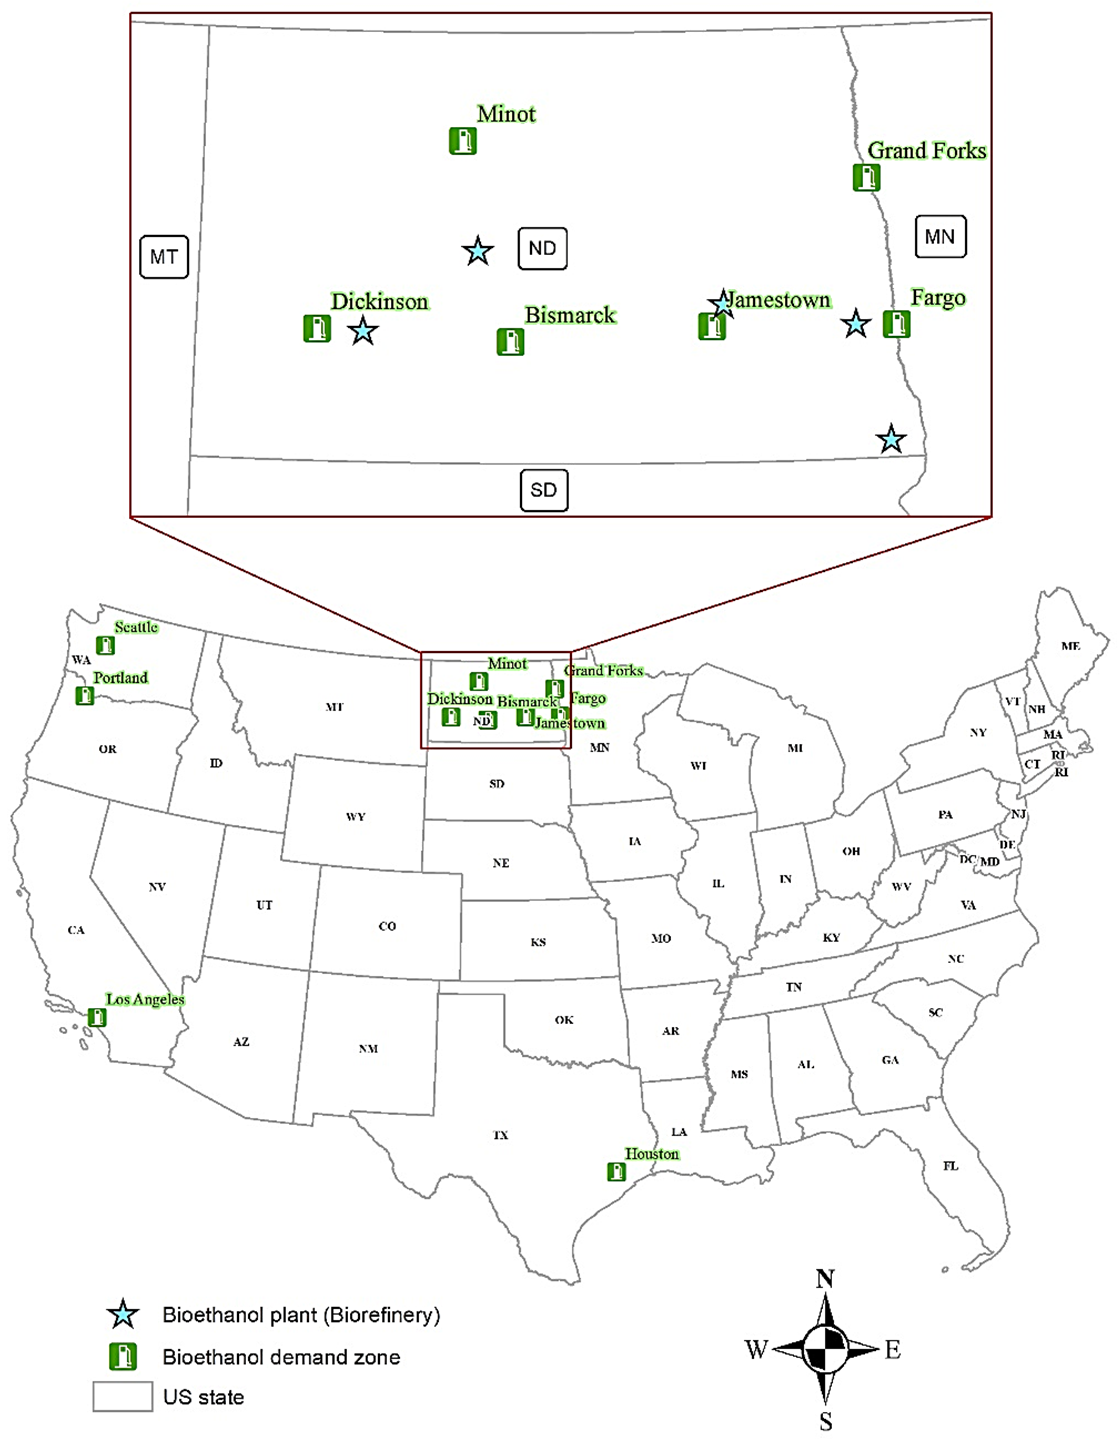

In [33]:
from IPython import display
display.Image('D:\Other\My_Optimization_projects\PhD Big biomass second incentive paper\Files from PhD\Demand_Points.png',
             width=600, height=500)

In [34]:
# Importing Gurobi to python
import gurobipy as gp
from gurobipy import GRB

import pandas as pd

In [35]:
# Create a new model for corn stover to biofuelanol supply chain
m = gp.Model("SupplyChain_Network_Design_biofuel_Stover_MILP")

In [36]:
# Creating Sets and Parameters
Suppliers = ['SE','EC','NE','SC','CENTRAL','NC','SW','WC','NW']

Biorefineries = ['Blue_Flint_Ethanol','Dakota_Spirit_AgEnergy_LLC',
                 'Red_Trail_Energy','Tharaldson_Ethanol',
                 'Hankinson_Renewable_Energy']

Demand_Points_InState = ['Fargo','Jamestown','Grand_Forks',
                         'Minot','Bismarck','Dickinson']

Demand_Points_OutState = ['Houston','Los_Angeles','Portland','Seattle']

Supply = dict({'SE':4516148,'EC':2836333,
               'NE':1345988,'SC':697340,
               'CENTRAL':1622040,'NC':344736,
               'SW':104832,'WC':171864,'NW':98812}) # ton

Total_Demand = 443000000 #Gallons/Year

Total_Demand_InState = Total_Demand * 0.1  # 10% of production
Total_Demand_OutState = Total_Demand - Total_Demand_InState  # 90% of production

# Demand is proportional to population
Demand_InState = dict({'Fargo':Total_Demand_InState*0.3833,
                       'Jamestown':Total_Demand_InState*0.0455,
                       'Grand_Forks':Total_Demand_InState*0.1526,
                       'Minot':Total_Demand_InState*0.1486,
                       'Bismarck':Total_Demand_InState*0.2049,
                       'Dickinson':Total_Demand_InState - Total_Demand_InState*(0.3833+0.04555+0.1526+0.1486+0.2049)})

Demand_OutState = dict({'Houston':Total_Demand_OutState*0.3588,
                        'Los_Angeles':Total_Demand_OutState*0.4946,
                        'Portland':Total_Demand_OutState*0.0524,
                        'Seattle':Total_Demand_OutState - Total_Demand_OutState*(0.3588+0.4946+0.0524)})

Biorefineries_Capacities = dict({'Blue_Flint_Ethanol':65000000,
                                 'Dakota_Spirit_AgEnergy_LLC':68000000,
                                 'Red_Trail_Energy':50000000,
                                 'Tharaldson_Ethanol':130000000,
                                 'Hankinson_Renewable_Energy':130000000})

Biorefineries_Construction = dict({'Blue_Flint_Ethanol':51808852,
                                 'Dakota_Spirit_AgEnergy_LLC':53713125,
                                 'Red_Trail_Energy':42000000,
                                 'Tharaldson_Ethanol':90204451,
                                 'Hankinson_Renewable_Energy':90204451})

Purchase_cost_biomass = 45  # $/ton
Conversion_rate_biofuel = 80.6  # gallons/ton
conversion_rate_biofuel_coproduct = 0.0085  # ton/gallon
Transport_fixed_cost_truck_biomass = 6
Transport_variable_cost_truck_biomass = 0.08
Transport_fixed_cost_truck_biofuel = 0.01159
Transport_variable_cost_truck_biofuel = 0.00024
Transport_fixed_cost_rail_biofuel = 0.06183
Transport_variable_cost_rail_biofuel = 0.000069
Production_variable_cost = 0.9  # $/gallon
Selling_price_biofuel = 1.4  # $/gallon
Selling_price_biofuel_coproduct = 134  # $/ton


# Creating Routes_Distance dictionary for Suppliers to Biorefineries
Routes_Supplier_Biorefinery = [(i,k) for i in Suppliers 
                               for k in Biorefineries]

Distance_Supplier_Biorefinery = [232,84,263,80,58,  #SE
                                190,68,250,50,120,  #EC
                                218,138,307,148,214, #NE
                                86,143,107,200,249,  #SC
                                121,61,196,118,194,  #CENTRAL
                                136,165,224,225,297,  #NC
                                160,246,61,304,378,  #SW
                                29,163,120,249,302,  #WC
                                102,219,185,283,359]  #NW

Routes_Distance_Supplier_Biorefinery = dict(zip(Routes_Supplier_Biorefinery,
                                                Distance_Supplier_Biorefinery))

# Creating Routes_Distance dictionary for Biorefineries to In-state Demand Points
Routes_Biorefinery_InState = [(k,e) for k in Biorefineries 
                               for e in Demand_Points_InState]

Distance_Biorefinery_InState = [239,145,231,51,62,126,
                                88,12,137,181,115,211,
                               298,207,354,178,108,25,
                               24,77,79,244,176,271,
                               50,127,126,297,248,336]

Routes_Distance_Biorefinery_InState = dict(zip(Routes_Biorefinery_InState,
                                                Distance_Biorefinery_InState))

# Creating Routes_Distance dictionary for Biorefineries to Out-of-state Demand Points
Routes_Biorefinery_OutState = [(k,r) for k in Biorefineries 
                               for r in Demand_Points_OutState]

Distance_Biorefinery_OutState = [1727,2478,1504,1450,
                                1565,2413,1484,1430,
                                1758,2347,1373,1319,
                                1503,2351,1520,1466,
                                1455,2303,1624,1570]

Routes_Distance_Biorefinery_OutState = dict(zip(Routes_Biorefinery_OutState,
                                                Distance_Biorefinery_OutState))

In [37]:
# Create variables
Q_biomass_ik = m.addVars(Routes_Supplier_Biorefinery, vtype=GRB.CONTINUOUS,
                      name="Quantity_biomass_shipped_Supplier_Biorefinery")  # bushel
Q_biofuel_ke = m.addVars(Routes_Biorefinery_InState, vtype=GRB.CONTINUOUS,
                      name="Quantity_biofuel_shipped_Biorefinery_InState") # gallon
Q_biofuel_kr = m.addVars(Routes_Biorefinery_OutState, vtype=GRB.CONTINUOUS,
                      name="Quantity_biofuel_shipped_Biorefinery_OutState") # gallon
Binary_biorefinery = m.addVars(Biorefineries, vtype=GRB.BINARY,
                      name="Binary_biorefinery") # 0 or 1

In [38]:
obj_rev_biofuel = gp.quicksum(Q_biofuel_ke[k,e] * Selling_price_biofuel 
                              for k in Biorefineries 
                              for e in Demand_Points_InState) + gp.quicksum(Q_biofuel_kr[k,r] * Selling_price_biofuel
                                                                            for k in Biorefineries
                                                                            for r in Demand_Points_OutState)

obj_rev_coprod = gp.quicksum(Q_biofuel_ke[k,e] * Selling_price_biofuel_coproduct*conversion_rate_biofuel_coproduct 
                              for k in Biorefineries 
                              for e in Demand_Points_InState) + gp.quicksum(Q_biofuel_kr[k,r] *Selling_price_biofuel_coproduct
                                                                            * conversion_rate_biofuel_coproduct
                                                                            for k in Biorefineries
                                                                            for r in Demand_Points_OutState)

obj_cost_biomass_purchase = gp.quicksum(Q_biomass_ik[i,k] * Purchase_cost_biomass
                                        for i in Suppliers
                                        for k in Biorefineries)

obj_transport_cost_sup_bioref = (gp.quicksum((Q_biomass_ik[i,k] * Routes_Distance_Supplier_Biorefinery[i,k])
                                             *Transport_variable_cost_truck_biomass
                                             for i in Suppliers
                                             for k in Biorefineries)
                                 + gp.quicksum(Q_biomass_ik[i,k] * Transport_fixed_cost_truck_biomass
                                               for i in Suppliers
                                               for k in Biorefineries))

obj_transport_cost_bioref_InState = (gp.quicksum((Q_biofuel_ke[k,e] * Routes_Distance_Biorefinery_InState[k,e])
                                                 *Transport_variable_cost_truck_biofuel
                                                 for k in Biorefineries
                                                 for e in Demand_Points_InState)
                                     + (gp.quicksum(Q_biofuel_ke[k,e] * Transport_fixed_cost_truck_biofuel
                                                   for k in Biorefineries
                                                   for e in Demand_Points_InState)))

obj_transport_cost_bioref_OutState = (gp.quicksum((Q_biofuel_kr[k,r] * Routes_Distance_Biorefinery_OutState[k,r])
                                                  *Transport_variable_cost_rail_biofuel 
                                                  for k in Biorefineries
                                                  for r in Demand_Points_OutState)
                                      + (gp.quicksum(Q_biofuel_kr[k,r] * Transport_fixed_cost_rail_biofuel
                                                    for k in Biorefineries
                                                    for r in Demand_Points_OutState)))

obj_production_cost = (gp.quicksum(Q_biofuel_ke[k,e] * Production_variable_cost
                                   for k in Biorefineries
                                   for e in Demand_Points_InState) 
                       + gp.quicksum(Q_biofuel_kr[k,r] * Production_variable_cost
                                     for k in Biorefineries
                                     for r in Demand_Points_OutState))

obj_open_bioref_cost = gp.quicksum(Binary_biorefinery[k] * Biorefineries_Construction[k] for k in Biorefineries)


In [39]:
# Set objective
m.setObjective(obj_rev_biofuel
               + obj_rev_coprod
               - obj_cost_biomass_purchase 
               - obj_transport_cost_sup_bioref
               - obj_transport_cost_bioref_InState
               - obj_transport_cost_bioref_OutState
               - obj_production_cost
               - obj_open_bioref_cost,
               GRB.MAXIMIZE)

In [40]:
# Add constraints
Supply_Limits = m.addConstrs( (gp.quicksum(Q_biomass_ik.select(i,"*")) <= Supply[i]
                                          for i in Suppliers ),
                             name="Supply_Limits")

Flow_Contraints = m.addConstrs( (gp.quicksum(Q_biomass_ik.select("*",k))*Conversion_rate_biofuel == 
                                     gp.quicksum(Q_biofuel_ke.select(k,"*"))
                                      + gp.quicksum(Q_biofuel_kr.select(k,"*"))
                                     for k in Biorefineries),
                                   name="Flow_Contraints")

Capacity_Contraints = m.addConstrs((gp.quicksum(Q_biofuel_ke.select(k,"*"))
                                      + gp.quicksum(Q_biofuel_kr.select(k,"*")) <= 
                                       Biorefineries_Capacities[k]*Binary_biorefinery[k]
                                    for k in Biorefineries),
                                   name="Flow_Contraints")

Demand_InState_Satisfaction = m.addConstrs( (gp.quicksum(Q_biofuel_ke.select("*",e))  == 
                                             Demand_InState[e]
                                             for e in Demand_Points_InState ),
                                           name="Demand_InState_Satisfaction")

Demand_OutState_Satisfaction = m.addConstrs( (gp.quicksum(Q_biofuel_kr.select("*",r)) == 
                                              Demand_OutState[r]
                                              for r in Demand_Points_OutState ),
                                            name="Demand_OutState_Satisfaction")

In [41]:
# Optimize model
m.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)


Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


Optimize a model with 29 rows, 100 columns and 245 nonzeros


Optimize a model with 29 rows, 100 columns and 245 nonzeros


Model fingerprint: 0x869709d5


Model fingerprint: 0x869709d5


Variable types: 95 continuous, 5 integer (5 binary)


Variable types: 95 continuous, 5 integer (5 binary)


Coefficient statistics:


Coefficient statistics:


  Matrix range     [1e+00, 1e+08]


  Matrix range     [1e+00, 1e+08]


  Objective range  [1e+00, 9e+07]


  Objective range  [1e+00, 9e+07]


  Bounds range     [1e+00, 1e+00]


  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+05, 2e+08]


  RHS range        [1e+05, 2e+08]


         Consider reformulating model or setting NumericFocus parameter


         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


         to avoid numerical issues.


Presolve time: 0.00s


Presolve time: 0.00s


Presolved: 29 rows, 100 columns, 245 nonzeros


Presolved: 29 rows, 100 columns, 245 nonzeros


Variable types: 95 continuous, 5 integer (5 binary)


Variable types: 95 continuous, 5 integer (5 binary)


Root relaxation: objective 1.083756e+07, 66 iterations, 0.00 seconds


Root relaxation: objective 1.083756e+07, 66 iterations, 0.00 seconds


    Nodes    |    Current Node    |     Objective Bounds      |     Work


    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


     0     0 1.0838e+07    0    1          - 1.0838e+07      -     -    0s


     0     0 1.0838e+07    0    1          - 1.0838e+07      -     -    0s


H    0     0                    1.083570e+07 1.0838e+07  0.02%     -    0s


H    0     0                    1.083570e+07 1.0838e+07  0.02%     -    0s


Explored 1 nodes (66 simplex iterations) in 0.02 seconds


Explored 1 nodes (66 simplex iterations) in 0.02 seconds


Thread count was 12 (of 12 available processors)


Thread count was 12 (of 12 available processors)


Solution count 1: 1.08357e+07 


Solution count 1: 1.08357e+07 


Optimal solution found (tolerance 1.00e-04)


Optimal solution found (tolerance 1.00e-04)


Best objective 1.083569747054e+07, best bound 1.083569747054e+07, gap 0.0000%


Best objective 1.083569747054e+07, best bound 1.083569747054e+07, gap 0.0000%


In [42]:
# Display optimal values in a table
# Which biorefineris are going to be opened?
print("\n","Optimal Solution =", '\033[1m' , '$', f"{m.objVal:,.0f}", '\033[0m', "\n")
Network_flow = pd.DataFrame(columns=["Biorefinery", "Open"])
for k in Biorefineries:
    if Binary_biorefinery[k].x > 1e-6:
        Network_flow = Network_flow.append({"Biorefinery": k,
                                            "Open": Binary_biorefinery[k].x},
                                           ignore_index=True)
Network_flow.index=[''] * len(Network_flow)
Network_flow


 Optimal Solution =  $ 10,835,697  



,Biorefinery,Open
,Blue_Flint_Ethanol,1
,Dakota_Spirit_AgEnergy_LLC,1
,Red_Trail_Energy,1
,Tharaldson_Ethanol,1
,Hankinson_Renewable_Energy,1


In [43]:
# Display optimal values 
# Optimal routes and amount shipped from Suppliers to Biorefineries
Network_flow_ik = pd.DataFrame(columns=["From", "To", "Units_shipped"])
for Route in Routes_Supplier_Biorefinery:
    if Q_biomass_ik[Route].x > 1e-6:
        Network_flow_ik = Network_flow_ik.append({"From": Route[0], "To": Route[1], 
                                            "Units_shipped": Q_biomass_ik[Route].x}, 
                                           ignore_index=True)
Network_flow_ik.index=[''] * len(Network_flow_ik)
Network_flow_ik

,From,To,Units_shipped
,SE,Hankinson_Renewable_Energy,"1,612,903"
,EC,Tharaldson_Ethanol,"1,612,903"
,SC,Blue_Flint_Ethanol,"181,852"
,SC,Red_Trail_Energy,"515,488"
,CENTRAL,Blue_Flint_Ethanol,"353,924"
,CENTRAL,Dakota_Spirit_AgEnergy_LLC,"843,672"
,SW,Red_Trail_Energy,"104,832"
,WC,Blue_Flint_Ethanol,"171,864"
,NW,Blue_Flint_Ethanol,"98,812"


In [44]:
# Display optimal values 
# Optimal routes and amount shipped from Biorefineries to In-state demand zones
Network_flow_ke = pd.DataFrame(columns=["From", "To", "Units_shipped"])
for Route in Routes_Biorefinery_InState:
    if Q_biofuel_ke[Route].x > 1e-6:
        Network_flow_ke = Network_flow_ke.append({"From": Route[0], "To": Route[1], 
                                            "Units_shipped": Q_biofuel_ke[Route].x}, 
                                           ignore_index=True)
Network_flow_ke.index=[''] * len(Network_flow_ke)
Network_flow_ke

,From,To,Units_shipped
,Blue_Flint_Ethanol,Minot,"6,582,980"
,Blue_Flint_Ethanol,Bismarck,"9,077,070"
,Dakota_Spirit_AgEnergy_LLC,Jamestown,"2,015,650"
,Red_Trail_Energy,Dickinson,"2,881,715"
,Tharaldson_Ethanol,Fargo,"16,980,190"
,Tharaldson_Ethanol,Grand_Forks,"6,760,180"


In [45]:
# Display optimal values 
# Optimal routes and amount shipped from Biorefineries to Out-of-state demand zones
Network_flow_kr = pd.DataFrame(columns=["From", "To", "Units_shipped"])
for Route in Routes_Biorefinery_OutState:
    if Q_biofuel_kr[Route].x > 1e-6:
        Network_flow_kr = Network_flow_kr.append({"From": Route[0], "To": Route[1], 
                                            "Units_shipped": Q_biofuel_kr[Route].x}, 
                                           ignore_index=True)
Network_flow_kr.index=[''] * len(Network_flow_kr)
Network_flow_kr

,From,To,Units_shipped
,Blue_Flint_Ethanol,Portland,"11,782,410"
,Blue_Flint_Ethanol,Seattle,"37,557,540"
,Dakota_Spirit_AgEnergy_LLC,Houston,"13,053,560"
,Dakota_Spirit_AgEnergy_LLC,Los_Angeles,"52,930,790"
,Red_Trail_Energy,Los_Angeles,"38,006,600"
,Red_Trail_Energy,Portland,"9,109,470"
,Tharaldson_Ethanol,Los_Angeles,"106,259,630"
,Hankinson_Renewable_Energy,Houston,"130,000,000"


In [46]:
sum(Network_flow_kr["Units_shipped"])

398700000.0

In [47]:
Total_Demand_OutState

398700000.0

In [48]:
pd.options.display.float_format = '{:,.0f}'.format

print("\n","Optimal Solution =", '\033[1m' , '$', f"{m.objVal:,.0f}", '\033[0m', "\n")

df = pd.DataFrame({'Objective_elements':['Revenue_from_selling_biofuel', 
                                         'Revenue_from_selling_biofuel_coproduct',
                                         'Biomass_purchasing_cost',
                                         'Transportation_cost',
                                        'Biofuel_production_cost',
                                        'Biorefineries_construction_cost'],
                   'Objective_values':[(sum(Network_flow_ke["Units_shipped"])+sum(Network_flow_kr["Units_shipped"]))*Selling_price_biofuel,
                                       (sum(Network_flow_ke["Units_shipped"])+sum(Network_flow_kr["Units_shipped"]))*(Selling_price_biofuel_coproduct*conversion_rate_biofuel_coproduct),
                                      sum(Network_flow_ik["Units_shipped"])*Purchase_cost_biomass,
                                      (sum((Q_biomass_ik[i,k].x * Routes_Distance_Supplier_Biorefinery[i,k])
                                             *Transport_variable_cost_truck_biomass
                                             for i in Suppliers
                                             for k in Biorefineries)+
                                      sum(Q_biomass_ik[i,k].x * Transport_fixed_cost_truck_biomass
                                               for i in Suppliers
                                               for k in Biorefineries))
                                       +
                                      (sum((Q_biofuel_ke[k,e].x * Routes_Distance_Biorefinery_InState[k,e])
                                                 *Transport_variable_cost_truck_biofuel
                                                 for k in Biorefineries
                                                 for e in Demand_Points_InState)
                                     + (sum(Q_biofuel_ke[k,e].x * Transport_fixed_cost_truck_biofuel
                                                   for k in Biorefineries
                                                   for e in Demand_Points_InState)))
                                       +
                                      (sum((Q_biofuel_kr[k,r].x * Routes_Distance_Biorefinery_OutState[k,r])
                                                  *Transport_variable_cost_rail_biofuel 
                                                  for k in Biorefineries
                                                  for r in Demand_Points_OutState)
                                      + (sum(Q_biofuel_kr[k,r].x * Transport_fixed_cost_rail_biofuel
                                                    for k in Biorefineries
                                                    for r in Demand_Points_OutState))),
                                      (sum(Network_flow_ke["Units_shipped"])
                                       +sum(Network_flow_kr["Units_shipped"]))*(Production_variable_cost),
                                      sum(Binary_biorefinery[k].x * Biorefineries_Construction[k] for k in Biorefineries)]}
                 ).set_index('Objective_elements')
df



 Optimal Solution =  $ 10,835,697  



,Objective_values
Objective_elements,
Revenue_from_selling_biofuel,"620,196,899"
Revenue_from_selling_biofuel_coproduct,"504,574,477"
Biomass_purchasing_cost,"247,331,270"
Transportation_cost,"139,975,524"
Biofuel_production_cost,"398,698,006"
Biorefineries_construction_cost,"327,930,879"
